# Welcome to the Modular Multimodal Data Fusion ML Pipeline for stress detection for the WESAD Database

## Table of contents






## Getting Started:
First, download necessary packages, if you are using a venv such as Conda, activate this first.

In [ ]:
%pip install -r requirements.txt

## Data Installation
If you are on Linux, run this cell to download and extract the WESAD dataset automatically, otherwise download manually [here](https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download) and unzip the `WESAD` file into the `wesad` directory i.e. `wesad/WESAD/`

In [ ]:
%cd src/wesad && bash download_database.sh
%cd ../..

## Data Preprocessing

This will automatically extract the biosensor data from the WESAD directory into several merged files in `.pkl` format.

This will take around 10 minutes depending on the machine.

In [ ]:
from src.wesad.data_preprocessing import WESADDataPreprocessor

preprocessor = WESADDataPreprocessor('src/wesad/WESAD/')
preprocessor.preprocess()

## Signal Preprocessing Steps
We will preprocess each signal with their respective preprocessing steps:

### Chest Signals

#### ECG
- **Smoothing**: Savitzky–Golay filter with window size 11 and order 3.
- **Filtering**: Butterworth band-pass filter of order 3 with cutoff frequencies 0.7 Hz and 3.7 Hz.

#### EMG
- **Smoothing**: Savitzky–Golay filter with window size 11 and order 3.
- **Filtering**: Butterworth lowpass filter of order 3 with cutoff frequency 0.5 Hz.

#### EDA
- **Smoothing**: Savitzky–Golay filter with window size 11 and order 3.
- **Filtering**: Butterworth lowpass filter of order 2 with cutoff frequency 5 Hz.

#### TEMP
- **Smoothing**: Savitzky–Golay filter with window size 11 and order 3.

#### RESP
- **Smoothing**: Savitzky–Golay filter with window size 11 and order 3.
- **Filtering**: Butterworth band-pass filter of order 3 with cutoff frequencies 0.1 Hz and 0.35 Hz.

#### ACC
- **Smoothing**: Savitzky–Golay filter with window size 31 and order 5.

### Wrist Signals

#### BVP
- **Filtering**: Butterworth band-pass filter of order 3 with cutoff frequencies 0.7 Hz and 3.7 Hz.

#### TEMP
- **Smoothing**: Savitzky–Golay filter with window size 11 and order 3.

#### ACC
- **Filtering**: Finite Impulse Response (FIR) filter with a length of 64 with a cut-off frequency of 0.4 Hz.


In [ ]:
# set config_files
CHEST_CONFIG = 'config_files/dataset/wesad_chest_configuration.json'
WRIST_CONFIG = 'config_files/dataset/wesad_wrist_configuration.json'

In [ ]:
from src.ml_pipeline.preprocessing import SignalPreprocessor

# preprocess the chest data
signal_preprocessor = SignalPreprocessor('src/wesad/WESAD/raw/merged_chest.pkl', 'src/wesad/WESAD/cleaned/chest_preprocessed.pkl', CHEST_CONFIG)
signal_preprocessor.preprocess_signals()

# preprocess the wrist data
signal_preprocessor = SignalPreprocessor('src/wesad/WESAD/raw/merged_wrist.pkl', 'src/wesad/WESAD/cleaned/wrist_preprocessed.pkl', WRIST_CONFIG, wrist=True)
signal_preprocessor.preprocess_signals()

## Data Augmentation and Splitting
Data augmentation will take the form of a sliding window. Once the data is augmented, each sample will then be split into smaller segments

In [ ]:
from src.ml_pipeline.data_loader import DataAugmenter

WINDOW_LENGTH = 60
SLIDING_LENGTH = 5
SPLIT_LENGTH = 10 # this will split each 60 second segments into 6 x 10 second segments

WRIST_CONFIG = 'config_files/dataset/wesad_wrist_configuration.json'

wrist_augmenter = DataAugmenter('src/wesad/WESAD/cleaned/wrist_preprocessed.pkl', WRIST_CONFIG) 
batches = wrist_augmenter.augment_data(WINDOW_LENGTH, SLIDING_LENGTH)
wrist_splitted_segments = wrist_augmenter.split_segments(batches, WINDOW_LENGTH//SPLIT_LENGTH)

## Traditional Machine Learning

The manual feature extraction derives features in the time, frequency and non-linear domains.

In [ ]:
from src.ml_pipeline.feature_extraction import ManualFE

WINDOW_LENGTH = 60
SLIDING_LENGTH = 5
SPLIT_LENGTH = 10 # this will split each 60 second segments into 6 x 10 second segments
WRIST_CONFIG = 'config_files/dataset/wesad_wrist_configuration.json'
WRIST_FE = f'src/wesad/WESAD/manual_fe/wrist_manual_fe/{WINDOW_LENGTH}s_{SLIDING_LENGTH}s_{SPLIT_LENGTH}s/wrist_features.hdf5'

manual_fe = ManualFE(wrist_splitted_segments, WRIST_FE, WRIST_CONFIG)
manual_fe.extract_features()

### Prepare LOSOCV Datasets

Now, using the preprocessed `.pkl` files we will make it into a dataloader with LOSOCV (Leave one subject out cross validation). The data augmented samples will be used in the training set but ignored in the test set.

In [ ]:
from src.ml_pipeline.data_loader import LOSOCVDataLoader

WINDOW_LENGTH = 60
SLIDING_LENGTH = 5
SPLIT_LENGTH = 10 # this will split each 60 second segments into 6 x 10 second segments
WRIST_CONFIG = 'config_files/dataset/wesad_wrist_configuration.json'
# WRIST_FE = f'src/wesad/WESAD/manual_fe/wrist_manual_fe/{WINDOW_LENGTH}s_{SLIDING_LENGTH}s_{SPLIT_LENGTH}s/wrist_features.hdf5'
WRIST_FE = f'src/wesad/WESAD/manual_fe/test203/wrist_manual_fe_{WINDOW_LENGTH}s_{SLIDING_LENGTH}s_{SPLIT_LENGTH}s.hdf5'

dataloader_params = {
    'batch_size': 32,
    'shuffle': True,
    # 'num_workers': 4
}
losocv_loader = LOSOCVDataLoader(WRIST_FE, WRIST_CONFIG, **dataloader_params)

# Prepare the datasets
DATASETS_PATH = losocv_loader.prepare_datasets()

### Train and Validate Models with LOSOCV

Now we can use the prepared datasets and form dataloaders which will then be used to perform LOSOCV on the models. Using the config file we can set the models that we want to test and their corresponding hyperparameters.

In [ ]:
from src.ml_pipeline.data_loader import LOSOCVDataLoader
from src.ml_pipeline.train import TraditionalMLTrainer
from src.utils import save_var

WINDOW_LENGTH = 60
SLIDING_LENGTH = 5
SPLIT_LENGTH = 10 # this will split each 60 second segments into 6 x 10 second segments
WRIST_CONFIG = 'config_files/dataset/wesad_wrist_configuration.json'
WRIST_FE = f'src/wesad/WESAD/manual_fe/wrist_manual_fe/{WINDOW_LENGTH}s_{SLIDING_LENGTH}s_{SPLIT_LENGTH}s/wrist_features.hdf5'

dataloader_params = {
    'batch_size': 32,
    'shuffle': True
    # 'num_workers': 4
}

# Load tradtional model config
losocv_loader = LOSOCVDataLoader(WRIST_FE, WRIST_CONFIG, **dataloader_params)
dataloaders = losocv_loader.get_data_loaders(DATASETS_PATH)
TRADTIONAL_ML_CONFIG = 'config_files/model_training/traditional/traditional_models.json'

results = []
for i, (subject_id, loaders) in enumerate(dataloaders.items()):
    train_loader = loaders['train']
    val_loader = loaders['val']
    
    print(f'Fold {i}')
    print(f'Train: {len(train_loader.dataset)}')
    print(f'Val: {len(val_loader.dataset)}')
    print()

    # Initialize trainer
    trainer = TraditionalMLTrainer(TRADTIONAL_ML_CONFIG, train_loader, val_loader)

    # trained_models = trainer.tune_hyperparameters(n_jobs=4, cv=None, verbose=2)
    trained_models = trainer.train()

    result = trainer.validate(trained_models)
    print(result)
    results.append(result)

# save the results to pkl
save_var(results, 'src/wesad/WESAD/results/traditional_models/wrist_results.pkl')

### Visualize Results

In [ ]:
from src.ml_pipeline.analysis import ModelResultsAnalysis
from src.utils import load_var

results = load_var('src/wesad/WESAD/results/traditional_models/wrist_results.pkl')

analysis = ModelResultsAnalysis(results)
analysis.analyze_collective()

# Deep Learning Methods


## Self-Attention Network Alongside Manual Feature Extraction

### Prepare LOSOCV Datasets on a Per Sensor Basis

Now, using the preprocessed `.pkl` files we will make it into a dataloader with LOSOCV (Leave one subject out cross validation) on a per sensor basis. The data augmented samples will be used in the training set but ignored in the test set.

In [ ]:
from src.ml_pipeline.data_loader import LOSOCVSensorDataLoader

WINDOW_LENGTH = 60
SLIDING_LENGTH = 5
SPLIT_LENGTH = 10 # this will split each 60 second segments into 6 x 10 second segments
WRIST_CONFIG = 'config_files/dataset/wesad_wrist_configuration.json'
# WRIST_FE = f'src/wesad/WESAD/manual_fe/wrist_manual_fe/{WINDOW_LENGTH}s_{SLIDING_LENGTH}s_{SPLIT_LENGTH}s/wrist_features.hdf5'
WRIST_FE = f'src/wesad/WESAD/manual_fe/test203/wrist_manual_fe_{WINDOW_LENGTH}s_{SLIDING_LENGTH}s_{SPLIT_LENGTH}s.hdf5'

dataloader_params = {
    'batch_size': 32,
    'shuffle': True,
    # 'num_workers': 4
}
losocv_loader = LOSOCVSensorDataLoader(WRIST_FE, WRIST_CONFIG, **dataloader_params)

# Prepare the datasets
DATASETS_PATH = losocv_loader.prepare_datasets()

### Train and Validate Models with LOSOCV

Now we can use the prepared datasets and form dataloaders which will then be used to perform LOSOCV on the models. Using the config file we can set the models that we want to test and their corresponding hyperparameters.

In [1]:
from src.ml_pipeline.train import PyTorchTrainer
from src.ml_pipeline.models.san import ModalityFusionNet
from src.ml_pipeline.data_loader import LOSOCVSensorDataLoader
from src.ml_pipeline.utils import get_active_key
from src.utils import save_var
import torch

WINDOW_LENGTH = 60
SLIDING_LENGTH = 5
SPLIT_LENGTH = 10 # this will split each 60 second segments into 6 x 10 second segments

WRIST_CONFIG = 'config_files/dataset/wesad_wrist_configuration.json'
# DATASETS_PATH = f'src/wesad/WESAD/manual_fe/test203/wrist_manual_fe_{WINDOW_LENGTH}s_{SLIDING_LENGTH}s_{SPLIT_LENGTH}s.hdf5'
DATASETS_PATH = f'src/wesad/WESAD/manual_fe/test203/losocv_datasets.pkl'
WRIST_FE = f'src/wesad/WESAD/manual_fe/test203/wrist_manual_fe_{WINDOW_LENGTH}s_{SLIDING_LENGTH}s_{SPLIT_LENGTH}s.hdf5'
SAN_MODEL_CONFIG = 'config_files/model_training/deep/san_config.json'

dataloader_params = {
    'batch_size': 32,
    'shuffle': True,
    # 'num_workers': 4
}

# Load tradtional model config
losocv_loader = LOSOCVSensorDataLoader(WRIST_FE, WRIST_CONFIG, **dataloader_params)
dataloaders, input_dims = losocv_loader.get_data_loaders(DATASETS_PATH)
TRADTIONAL_ML_CONFIG = 'config_files/model_training/random_forest_tuner.json'

num_classes = len(get_active_key(WRIST_CONFIG, 'labels'))

results = []
for i, (subject_id, loaders) in enumerate(dataloaders.items()):
    train_loader = loaders['train']
    val_loader = loaders['val']
    
    print(f'Fold {i}')
    print(f'Train: {len(train_loader.dataset)}')
    print(f'Val: {len(val_loader.dataset)}')
    print()

    # Initialize model
    model = ModalityFusionNet(input_dims=input_dims, embed_dim=128, hidden_dim=256, output_dim=num_classes)

    # Initialize trainer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainer = PyTorchTrainer(model, train_loader, val_loader, SAN_MODEL_CONFIG, device)
    trained_model_ckpt = trainer.train()

    result = trainer.validate(trained_model_ckpt)
    print(result)
    results.append(result)

# save the results to pkl
save_var(results, 'src/wesad/WESAD/results/SAN/wrist_results_{WINDOW_LENGTH}s_{SLIDING_LENGTH}s_{SPLIT_LENGTH}s.pkl')

Fold 0
Train: 154
Val: 12

Epoch: 0, | training loss: 0.2520
Epoch: 1, | training loss: 0.0000
{'ModalityFusionNet': {'accuracy': 1.0, 'confusion_matrix': array([[12]]), 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'loss': None}}
Fold 1
Train: 154
Val: 12

Epoch: 0, | training loss: 0.2639
Epoch: 1, | training loss: 0.0000
{'ModalityFusionNet': {'accuracy': 1.0, 'confusion_matrix': array([[12]]), 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'loss': None}}
Fold 2
Train: 154
Val: 12

Epoch: 0, | training loss: 0.2783
Epoch: 1, | training loss: 0.0000
{'ModalityFusionNet': {'accuracy': 1.0, 'confusion_matrix': array([[12]]), 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'loss': None}}
Fold 3
Train: 154
Val: 12

Epoch: 0, | training loss: 0.2350
Epoch: 1, | training loss: 0.0000
{'ModalityFusionNet': {'accuracy': 1.0, 'confusion_matrix': array([[12]]), 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'loss': None}}
Fold 4
Train: 154
Val: 12

Epoch: 0, | training loss: 0.2179

### Visualize Results

Variable loaded from src/wesad/WESAD/results/SAN/wrist_results_{WINDOW_LENGTH}s_{SLIDING_LENGTH}s_{SPLIT_LENGTH}s.pkl
ModalityFusionNet:
  Accuracy: 1.00000
  Precision: 1.00000
  Recall: 1.00000
  F1 Score: 1.00000


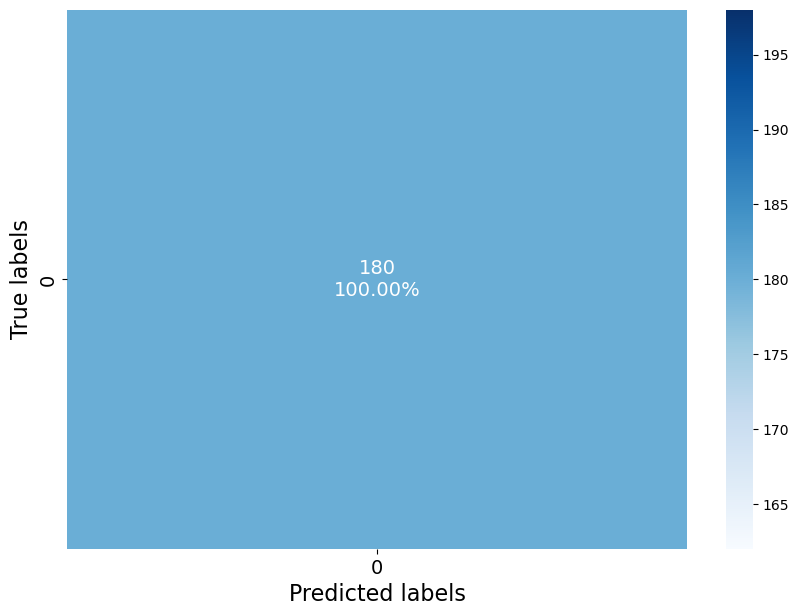

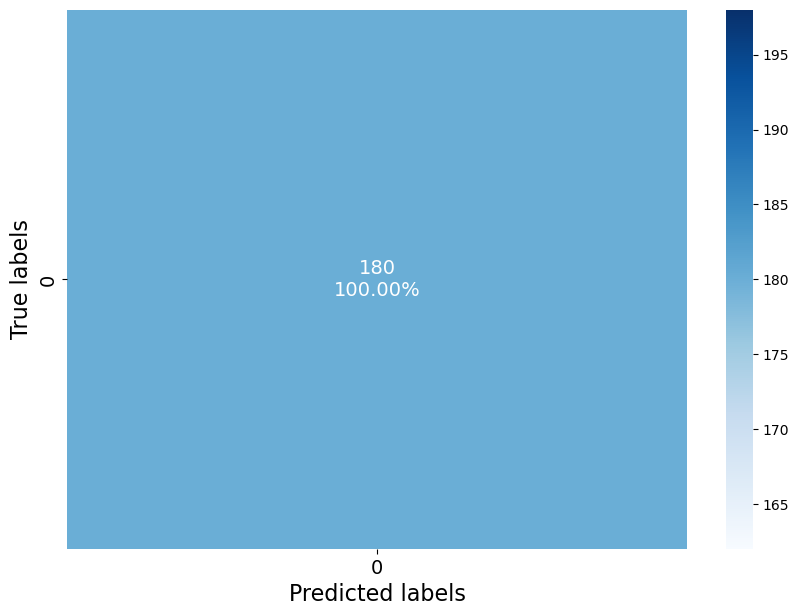

In [2]:
from src.ml_pipeline.analysis import ModelResultsAnalysis
from src.utils import load_var

WINDOW_LENGTH = 60
SLIDING_LENGTH = 5
SPLIT_LENGTH = 10 # this will split each 60 second segments into 6 x 10 second segments

results = load_var('src/wesad/WESAD/results/SAN/wrist_results_{WINDOW_LENGTH}s_{SLIDING_LENGTH}s_{SPLIT_LENGTH}s.pkl')

analysis = ModelResultsAnalysis(results)
analysis.analyze_collective()